# FB2NEP Workbook 7 – Data Transformation and Preparation for Modelling

Version 0.0.7

In this workbook we explore how to prepare variables for statistical modelling.

We consider:

- Why we sometimes transform variables before modelling.
- Log transformation, Box–Cox transformation and z-scoring.
- Visual comparison of original and transformed variables.
- Categorisation, quantiles and information loss.
- Truncation of analytical values (for example, LOD / LLOQ / ULOQ).

The focus is on understanding **why** transformations are used in epidemiological analyses,
and how they affect model assumptions and interpretation.

We begin with some background theory, using small simulated examples to illustrate:

- What a normal distribution looks like.
- Residuals and their distribution.
- Heteroskedasticity (changing variance with the level of a predictor).
- How one might decide whether to transform a variable or not.

We then work with the FB2NEP synthetic cohort to apply these ideas in practice.

Run the first code cell to set up the repository and load the data.

In [15]:
# FB2NEP bootstrap cell – use in *all* workbooks
#
# This cell initialises the repository context and loads the synthetic cohort
# into a DataFrame called df. It tries a few possible locations for scripts/bootstrap.py.

import pathlib
import runpy

bootstrap_candidates = [
    "scripts/bootstrap.py",
    "../scripts/bootstrap.py",
    "../../scripts/bootstrap.py",
]

bootstrap_ns = None

for rel in bootstrap_candidates:
    p = pathlib.Path(rel)
    if p.exists():
        print(f"Loading bootstrap from: {p}")
        bootstrap_ns = runpy.run_path(str(p))
        break
else:
    raise FileNotFoundError(
        "Could not find scripts/bootstrap.py. "
        "Please check that you are running this notebook inside fb2nep-epi."
    )

if "init" not in bootstrap_ns:
    raise RuntimeError("bootstrap.py does not define init().")

df, CTX = bootstrap_ns["init"]()

REPO_ROOT = CTX.repo_root
CSV_REL = CTX.csv_rel
IN_COLAB = CTX.in_colab

print("Repository root:", REPO_ROOT)
print("Main dataset:", CSV_REL)
print("df shape:", df.shape)
print("IN_COLAB:", IN_COLAB)

Loading bootstrap from: scripts/bootstrap.py
Dataset found: data/synthetic/fb2nep.csv ✅
Repository root: /Users/gunter/Documents/fb2nep-epi
Main dataset: data/synthetic/fb2nep.csv
df shape: (25000, 27)
IN_COLAB: False


## Background theory with simple examples

Before using the FB2NEP dataset, we illustrate a few key ideas with small simulated examples:

- What a **normal distribution** looks like.
- What **residuals** are and why we care about their distribution.
- What **heteroskedasticity** looks like in a residual plot.
- How one might decide whether a transformation is needed.

These examples are deliberately simple and are not based on real nutritional data.

We first import the Python packages required for this workbook:

- `numpy` and `pandas` for data handling.
- `matplotlib` for visualisation.
- `scipy.stats` for skewness and Box–Cox transformation.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

# For reproducible simulated examples
np.random.seed(11088)

### Background 1 – What is a normal distribution?

Many statistical methods assume that some quantity is approximately **normally distributed**.
The normal distribution is the familiar “bell-shaped” curve:

- Most values lie near the mean.
- Values become less frequent as we move further away from the mean.
- The distribution is symmetric around the mean.

We now simulate 10,000 values from a normal distribution with mean 0 and standard deviation 1
and plot a histogram.

In [ ]:
# Simulate data from a standard normal distribution
# mean = 0, standard deviation = 1

x_norm = np.random.normal(loc=0.0, scale=1.0, size=10_000)

plt.figure(figsize=(6, 4))
plt.hist(x_norm, bins=30)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Simulated standard normal distribution")
plt.tight_layout()
plt.show()

print("Mean:", x_norm.mean())
print("Standard deviation:", x_norm.std())
print("Skewness:", stats.skew(x_norm))

### Background 2 – What are residuals?

We start by looking at how well a simple linear model reproduces the data:

- The **fitted value** is the model’s prediction for each observation.
- Plotting **observed vs fitted** shows whether the model captures the *average* pattern.

We then look at **residuals** (observed − fitted):

- Residuals show what is left after the model has explained as much variation as it can.
- Their distribution (for example, symmetry, spread) is what many methods make assumptions about.


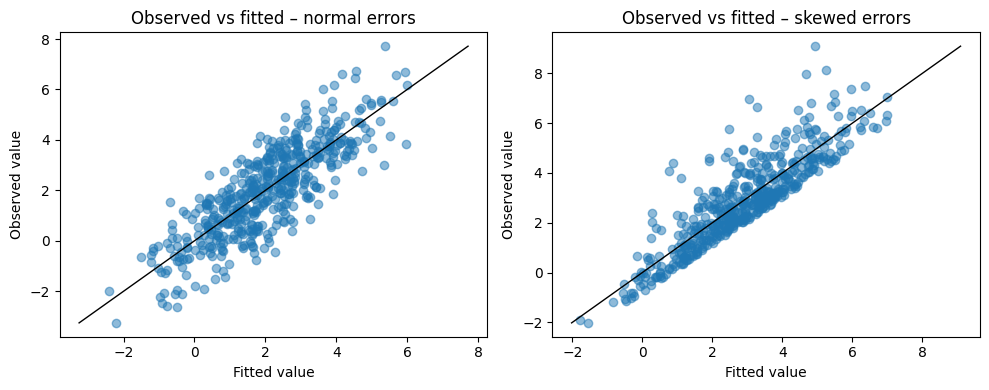

In [10]:
# Example 1: residuals approximately normal
# ----------------------------------------
# We simulate x from a normal distribution and y from a linear relation
# plus normal (Gaussian) error.

n = 500
x1 = np.random.normal(loc=0.0, scale=1.0, size=n)
epsilon1 = np.random.normal(loc=0.0, scale=1.0, size=n)  # normal residuals
y1 = 2.0 + 1.5 * x1 + epsilon1

# Fit a straight line y1 ~ x1 using numpy.polyfit
slope1, intercept1 = np.polyfit(x1, y1, 1)
fitted1 = intercept1 + slope1 * x1
residuals1 = y1 - fitted1

# Example 2: residuals clearly non-normal
# ---------------------------------------
# We use the same x, but generate skewed error terms (for example,
# from an exponential distribution).

epsilon2 = np.random.exponential(scale=1.0, size=n)  # skewed residuals
y2 = 2.0 + 1.5 * x1 + epsilon2

slope2, intercept2 = np.polyfit(x1, y2, 1)
fitted2 = intercept2 + slope2 * x1
residuals2 = y2 - fitted2

# Plot observed vs fitted values for the two examples
# ---------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

def add_identity_line(ax, x, y):
    """Add a y = x reference line over the range of fitted/observed values."""
    lo = min(x.min(), y.min())
    hi = max(x.max(), y.max())
    ax.plot([lo, hi], [lo, hi], color="black", linewidth=1)

# Example 1: approximately normal residuals
axes[0].scatter(fitted1, y1, alpha=0.5)
add_identity_line(axes[0], fitted1, y1)
axes[0].set_title("Observed vs fitted – normal errors")
axes[0].set_xlabel("Fitted value")
axes[0].set_ylabel("Observed value")

# Example 2: skewed residuals
axes[1].scatter(fitted2, y2, alpha=0.5)
add_identity_line(axes[1], fitted2, y2)
axes[1].set_title("Observed vs fitted – skewed errors")
axes[1].set_xlabel("Fitted value")
axes[1].set_ylabel("Observed value")

plt.tight_layout()
plt.show()


In both panels, the points lie roughly along the 45° line, so the *average* relation
is captured well by the straight line model. The difference between the two examples
will become clearer when we examine the residuals.
    

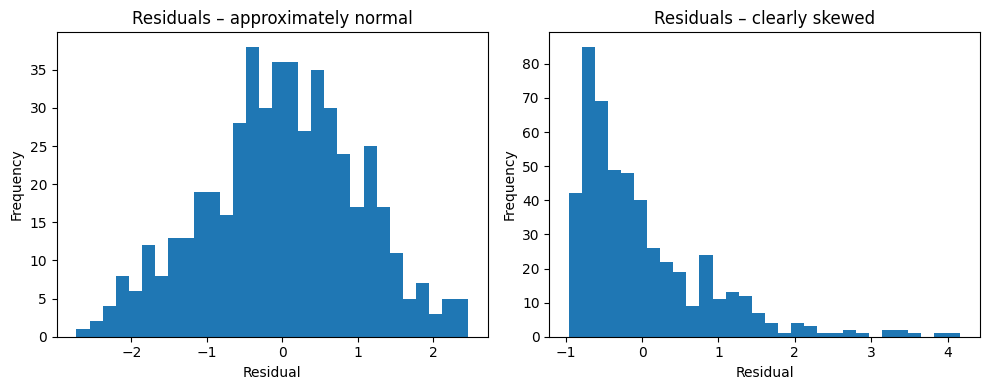

Example 1 residual skewness: -0.11312843853389909
Example 2 residual skewness: 1.7152877868279564


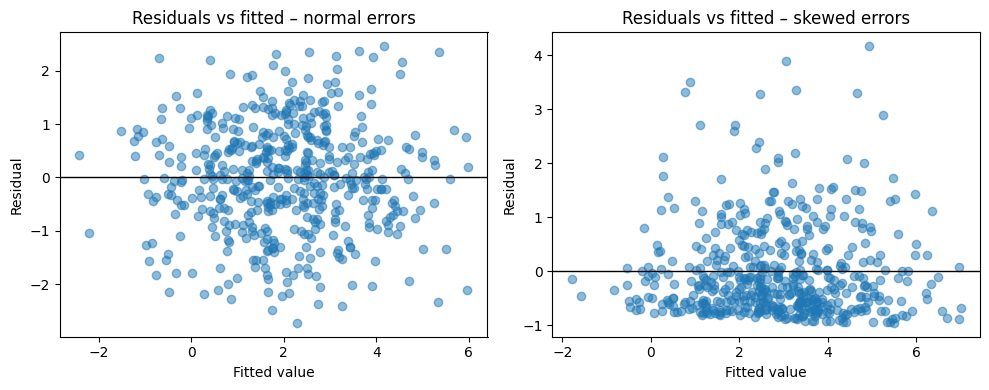

In [11]:
# Histograms of residuals for both cases
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(residuals1, bins=30)
axes[0].set_title("Residuals – approximately normal")
axes[0].set_xlabel("Residual")
axes[0].set_ylabel("Frequency")

axes[1].hist(residuals2, bins=30)
axes[1].set_title("Residuals – clearly skewed")
axes[1].set_xlabel("Residual")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

print("Example 1 residual skewness:", stats.skew(residuals1))
print("Example 2 residual skewness:", stats.skew(residuals2))

# Residuals vs fitted values
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(fitted1, residuals1, alpha=0.5)
axes[0].axhline(0.0, color="black", linewidth=1)
axes[0].set_title("Residuals vs fitted – normal errors")
axes[0].set_xlabel("Fitted value")
axes[0].set_ylabel("Residual")

axes[1].scatter(fitted2, residuals2, alpha=0.5)
axes[1].axhline(0.0, color="black", linewidth=1)
axes[1].set_title("Residuals vs fitted – skewed errors")
axes[1].set_xlabel("Fitted value")
axes[1].set_ylabel("Residual")

plt.tight_layout()
plt.show()


**Exercise – residuals and assumptions**

- Which example looks closer to the ideal of symmetric, roughly constant residuals?
- In which example would you be more confident about using methods that assume
  normally distributed residuals with constant variance?


### Background 3 – Heteroskedasticity (changing variance)

In many real data sets, the **spread** of residuals is not constant across the range of fitted values.
If the residuals fan out as the predicted value increases, this is called **heteroskedasticity**.

We now simulate a simple example where the variance of the error term increases with the level of x
and show a residual plot.

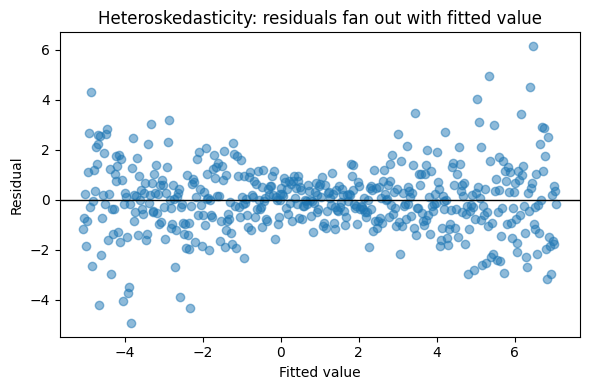

In [12]:
# Simulate heteroskedastic data
# -----------------------------
# We let the standard deviation of the error term increase with |x|.

x_h = np.linspace(-3, 3, n)
sigma_h = 0.5 + 0.5 * np.abs(x_h)  # larger variance for large |x|
epsilon_h = np.random.normal(loc=0.0, scale=sigma_h)
y_h = 1.0 + 2.0 * x_h + epsilon_h

slope_h, intercept_h = np.polyfit(x_h, y_h, 1)
fitted_h = intercept_h + slope_h * x_h
residuals_h = y_h - fitted_h

plt.figure(figsize=(6, 4))
plt.scatter(fitted_h, residuals_h, alpha=0.5)
plt.axhline(0.0, color="black", linewidth=1)
plt.xlabel("Fitted value")
plt.ylabel("Residual")
plt.title("Heteroskedasticity: residuals fan out with fitted value")
plt.tight_layout()
plt.show()

### Background 4 – How to decide whether to transform

In practice there is no automatic rule for when to transform a variable. Analysts usually combine:

- **Exploratory plots of the variable itself** (histograms, density plots) to see skewness.
- **Residual plots** from a model fitted on the original scale.
- **Subject-matter knowledge**, for example whether multiplicative (percentage) effects are plausible.

Some practical guidelines:

- If residuals are approximately symmetric and the variance is roughly constant across fitted values,
  a transformation is often unnecessary.
- If the predictor is strongly right-skewed and residuals are clearly non-normal or heteroskedastic,
  a log or Box–Cox transformation can help.
- If predictors are on very different scales and you mainly care about comparing effect sizes,
  z-scoring can be useful.
- Transformations should also respect interpretability: a modest gain in “niceness” of residual plots
  may not justify a scale that is hard to explain.


---
# Let's begin
---

## 1. Initial inspection of the FB2NEP data

We now return to the FB2NEP synthetic cohort. Before transforming variables, we:

- Check that the variables of interest exist.
- Obtain a first impression of their ranges and types.

In this workbook we will mainly use:

- `red_meat_g_d` (or `energy_kcal` as fallback) as an example of a skewed exposure.
- `BMI` (kg/m²) and `SBP` (systolic blood pressure, mmHg) as common continuous variables.

In [ ]:
from IPython.display import display

# Show the first rows (participants) of the dataset
display(df.head())

# Show data types of a subset of variables that we will use later.
cols_of_interest = [
    c for c in ["red_meat_g_d", "energy_kcal", "BMI", "SBP"] if c in df.columns
]
print("\nColumns of interest:", cols_of_interest)
display(df[cols_of_interest].dtypes)

## 2. Log transformation – nutrition data and log-normality

Many dietary and biomarker variables are **right-skewed**: most participants have low or moderate
values, with a long tail of high values. In nutrition, it is often more plausible to think in terms of
**proportional** changes (for example, doubling intake) than in terms of fixed absolute changes.

If a variable is approximately **log-normal** (that is, its logarithm is roughly normal), then:

- The variable itself is right-skewed.
- The log-transformed variable is closer to a normal distribution.
- Effects can often be interpreted in terms of percentage or fold-changes.

We now inspect the distribution of a skewed dietary variable and apply a log transformation.

Using variable: red_meat_g_d


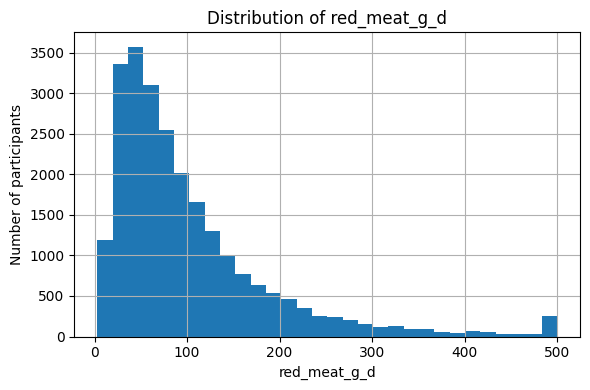

Number of non-missing values: 24375
Mean: 102.16216205128205
Median: 75.2
Skewness: 2.072092510287019


In [17]:
# Choose a variable that is likely to be right-skewed.
var = "red_meat_g_d" if "red_meat_g_d" in df.columns else "energy_kcal"
print(f"Using variable: {var}")

# Drop missing values for plotting and computing skewness.
x = df[var].dropna()

plt.figure(figsize=(6, 4))
x.hist(bins=30)
plt.xlabel(var)
plt.ylabel("Number of participants")
plt.title(f"Distribution of {var}")
plt.tight_layout()
plt.show()

print("Number of non-missing values:", x.shape[0])
print("Mean:", x.mean())
print("Median:", x.median())
print("Skewness:", stats.skew(x))

Like most dietary data, meat intake is skewed - other variables are often even more skewed.

What happens if we log-transform it?

Created column: log_red_meat_g_d (log-transformed red_meat_g_d)
Skewness (original): 2.072092510287019
Skewness (log-transformed): -0.07164601356618427


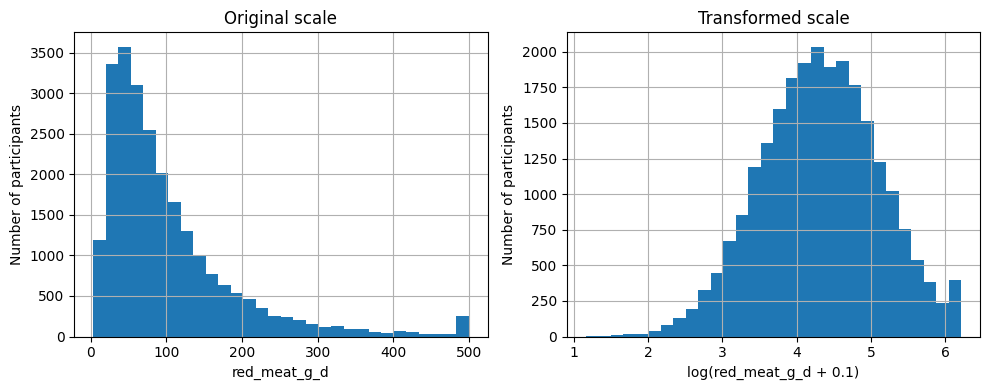

In [18]:
from scripts.helpers_tables import log_transform, plot_hist_pair

# Use a small constant to avoid problems if there are zeros.
log_const = 0.1
log_var_name = "log_" + var
df[log_var_name] = log_transform(df[var], constant=log_const)

print(f"Created column: {log_var_name} (log-transformed {var})")

# Compare skewness before and after log transformation.
x_log = df[log_var_name].dropna()
print("Skewness (original):", stats.skew(x))
print("Skewness (log-transformed):", stats.skew(x_log))

plot_hist_pair(
    original=df[var],
    transformed=df[log_var_name],
    original_label=var,
    transformed_label=f"log({var} + {log_const})",
)

### Exercise – log transformation

- Compare the histograms and skewness values before and after log transformation.
- Does the log-transformed variable look more symmetric?
- If you were to regress SBP on this exposure, would you consider using the log
  scale rather than the original scale? Why or why not?

## 3. Standardisation (z-scores) – making variables comparable

Variables such as BMI and SBP are measured on different scales and in different
units. When several such variables are included in a model, it can be useful to
standardise them so that:

- The mean is 0.
- The standard deviation is 1.

These standardised values are called **z-scores**. They are defined as:

$$ z_i = \frac{x_i - \bar{x}}{s_x} $$

where $\bar{x}$ is the sample mean and $s_x$ is the sample standard deviation.

In psychology and some areas of epidemiology it is common to report effects per
1 standard deviation increase, because this makes effect sizes comparable across
different variables.

In [19]:
from scripts.helpers_tables import z_score

for v in ["BMI", "SBP"]:
    if v in df.columns:
        z_name = "z_" + v
        df[z_name] = z_score(df[v])
        print(f"\nSummary of z-scored {v} (stored in {z_name}):")
        print(df[z_name].describe())


Summary of z-scored BMI (stored in z_BMI):
count    2.499500e+04
mean    -6.643482e-16
std      1.000000e+00
min     -2.957385e+00
25%     -6.703857e-01
50%      1.131587e-02
75%      6.710271e-01
max      4.211477e+00
Name: z_BMI, dtype: float64

Summary of z-scored SBP (stored in z_SBP):
count    2.364900e+04
mean    -4.466243e-16
std      1.000000e+00
min     -3.781250e+00
25%     -6.873933e-01
50%     -5.473434e-02
75%      6.165013e-01
max      4.721069e+00
Name: z_SBP, dtype: float64


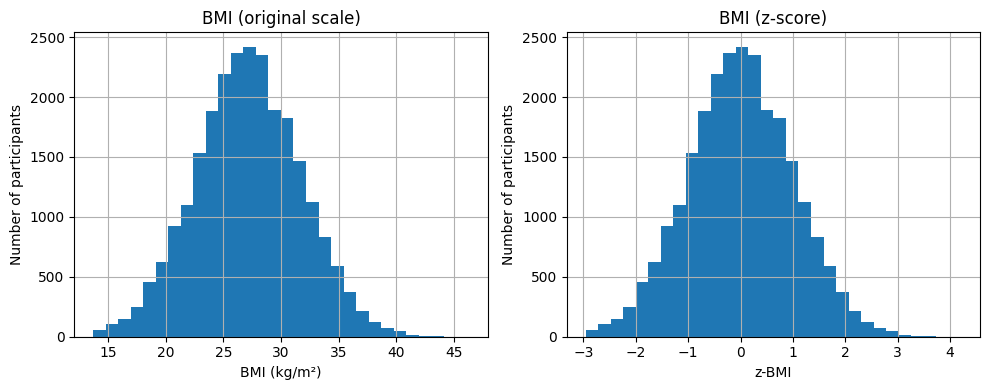

In [20]:
# Visualisation: compare the distributions of BMI and z-scored BMI.
if "BMI" in df.columns:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    df["BMI"].dropna().hist(bins=30)
    plt.xlabel("BMI (kg/m²)")
    plt.ylabel("Number of participants")
    plt.title("BMI (original scale)")

    plt.subplot(1, 2, 2)
    df["z_BMI"].dropna().hist(bins=30)
    plt.xlabel("z-BMI")
    plt.ylabel("Number of participants")
    plt.title("BMI (z-score)")

    plt.tight_layout()
    plt.show()

### Exercise – interpretation of z-scores

- Check the summary output for `z_BMI` and `z_SBP`.
  - Are the means close to 0 and the standard deviations close to 1?
- Imagine a regression model where the coefficient for `z_BMI` is 2.5 mmHg.
  - How would you describe this effect in words (per 1 standard deviation increase
    in BMI)?
  - How does this compare to a model where BMI is used in kg/m² without
    standardisation?

## 4. Box–Cox transformations – a flexible family

The log transformation is a special case of a more general family of power
transformations called **Box–Cox transformations**. Box–Cox chooses an exponent
(lambda, $\lambda$) that aims to make the distribution more symmetric.

For a variable $x$ that is strictly positive, the Box–Cox transformation is defined as

$$
x^{(\lambda)} =
\begin{cases}
\dfrac{x^{\lambda} - 1}{\lambda}, & \text{if } \lambda \neq 0, \\[6pt]
\log(x), & \text{if } \lambda = 0.
\end{cases}
$$

Key points:

- For $\lambda = 1$, the Box–Cox transform is essentially the original scale.
- For $\lambda = 0$, the transform corresponds to a log transform.
- The method requires $x > 0$. In practice, one often adds a small constant
  (for example, $x^{*} = x + c$) if some observations are zero or very small.

We now apply a Box–Cox transformation to the same skewed dietary variable and
compare its distribution with the original and log-transformed versions.


Created column: boxcox_red_meat_g_d (Box–Cox transformed red_meat_g_d)
Box–Cox lambda (λ): 0.034
Shift applied before Box–Cox: 0.0
Skewness (original): 2.072092510287019
Skewness (log): -0.07164601356618427
Skewness (Box–Cox): -0.0014882443951327762


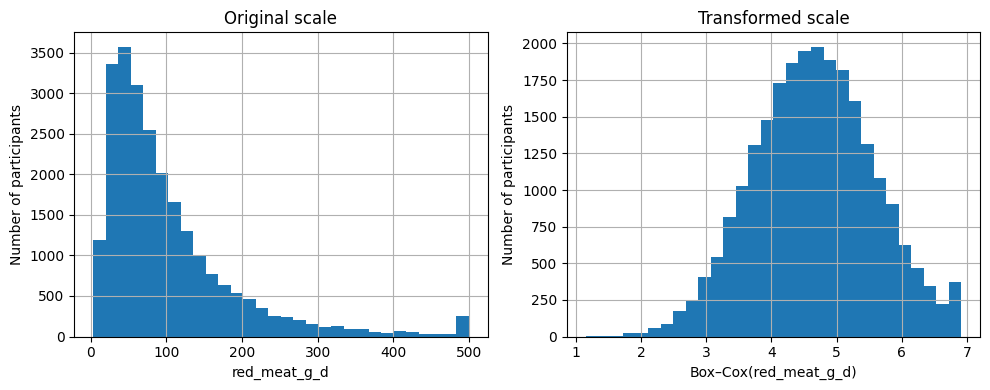

In [22]:
# Box–Cox transformation requires strictly positive values.
# We therefore shift the data if necessary.

x_bc = df[var].dropna()
min_x = x_bc.min()

shift = 0.0
if min_x <= 0:
    # Add a small positive amount so that the minimum becomes slightly > 0.
    shift = -min_x + 1e-6

x_bc_shifted = x_bc + shift

# Apply Box–Cox. stats.boxcox returns transformed data and the estimated lambda.
x_bc_transformed, lambda_bc = stats.boxcox(x_bc_shifted)

# Store Box–Cox transformed values in the DataFrame, aligned with the original index.
boxcox_var_name = "boxcox_" + var
df[boxcox_var_name] = np.nan
df.loc[x_bc.index, boxcox_var_name] = x_bc_transformed

print(f"Created column: {boxcox_var_name} (Box–Cox transformed {var})")
print(f"Box–Cox lambda (λ): {lambda_bc:.3f}")
print(f"Shift applied before Box–Cox: {shift}")

# Compare skewness for original, log and Box–Cox transformed data.
x_boxcox = df[boxcox_var_name].dropna()
print("Skewness (original):", stats.skew(x))
print("Skewness (log):", stats.skew(x_log))
print("Skewness (Box–Cox):", stats.skew(x_boxcox))

plot_hist_pair(
    original=df[var],
    transformed=df[boxcox_var_name],
    original_label=var,
    transformed_label=f"Box–Cox({var})",
)

### Exercise – log versus Box–Cox

- Compare the histograms and skewness values for the original, log-transformed and
  Box–Cox transformed variables.
- Which transformation appears to give the most symmetric distribution?
- Which transformation would you prefer to use in a model, and why? Consider both
  distributional properties and interpretability.

## 5. Categorisation and quantiles – useful but risky

Epidemiological papers often categorise continuous variables, for example:

- Clinical categories (for example, normal weight, overweight, obesity based on BMI).
- Quantiles such as tertiles, quartiles or quintiles of intake.

While categorisation can simplify presentation, it comes with several problems:

- **Information loss:** individuals with very different values may end up in the
  same category.
- **Arbitrary cut-points:** results can change if cut-points are moved slightly.
- **Reduced power:** categorisation usually reduces statistical power.

Quantiles are particularly important in nutrition:

- They are often used to describe the distribution (for example, median and interquartile range).
- They are also used to form exposure groups (for example, quintiles of intake).

However, the **extreme quantiles** (lowest and highest) can cover quite wide ranges of the underlying
variable, especially when the distribution is skewed. We explore this using BMI and BMI quantiles.

BMI quintiles (cut-points and ranges):
               min   25%   50%   75%   max
BMI_quintile                              
Q1            13.7  19.7  21.3  22.4  23.3
Q2            23.4  24.1  24.8  25.5  26.0
Q3            26.1  26.6  27.2  27.8  28.3
Q4            28.4  29.0  29.6  30.3  31.0
Q5            31.1  31.9  33.1  34.7  46.3


<positron-console-cell-23>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


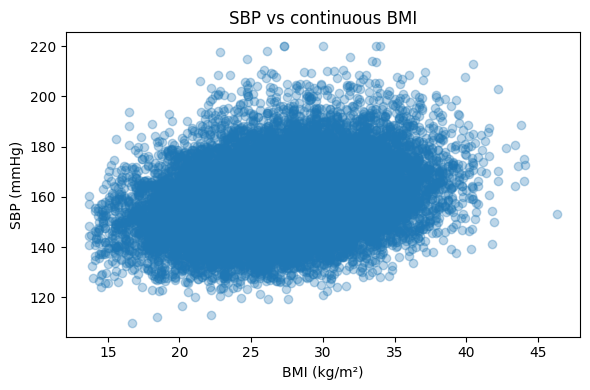

<Figure size 600x400 with 0 Axes>

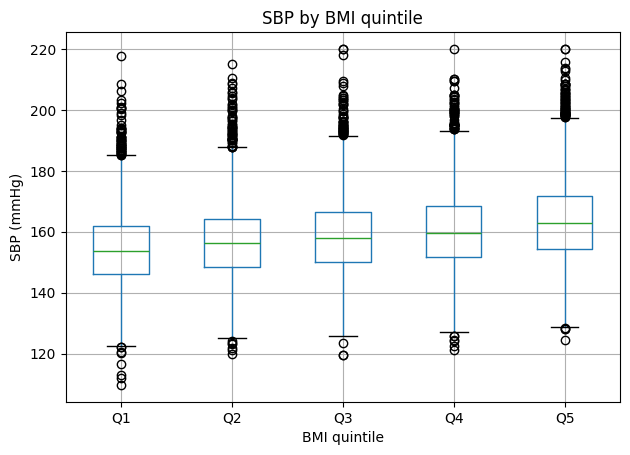


Mean SBP by BMI quintile:
BMI_quintile
Q1    154.247323
Q2    156.986549
Q3    158.778276
Q4    160.550128
Q5    163.694235
Name: SBP, dtype: float64


<positron-console-cell-23>:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [23]:
if {"BMI", "SBP"}.issubset(df.columns):
    # Create BMI quintiles using pandas.qcut.
    # qcut creates categories with (approximately) equal numbers of observations.
    df["BMI_quintile"] = pd.qcut(df["BMI"], 5, labels=["Q1", "Q2", "Q3", "Q4", "Q5"])

    print("BMI quintiles (cut-points and ranges):")
    print(
        df.groupby("BMI_quintile")["BMI"].describe()[["min", "25%", "50%", "75%", "max"]]
    )

    # Scatter plot of SBP vs continuous BMI.
    plt.figure(figsize=(6, 4))
    plt.scatter(df["BMI"], df["SBP"], alpha=0.3)
    plt.xlabel("BMI (kg/m²)")
    plt.ylabel("SBP (mmHg)")
    plt.title("SBP vs continuous BMI")
    plt.tight_layout()
    plt.show()

    # Boxplot of SBP by BMI quintile.
    plt.figure(figsize=(6, 4))
    df.boxplot(column="SBP", by="BMI_quintile")
    plt.xlabel("BMI quintile")
    plt.ylabel("SBP (mmHg)")
    plt.title("SBP by BMI quintile")
    plt.suptitle("")  # Remove the default super-title.
    plt.tight_layout()
    plt.show()

    # Compare mean SBP between quintiles.
    print("\nMean SBP by BMI quintile:")
    print(df.groupby("BMI_quintile")["SBP"].mean())

### Exercise – categories and extreme quantiles

1. Compare the scatter plot of SBP vs continuous BMI with the boxplot of SBP by
   BMI quintiles.
   - What information is visible in the scatter plot but lost when using quintiles?
   - How much variation in SBP exists **within** each quintile?

2. Look at the ranges of BMI within each quintile.
   - Are the lowest and highest values in Q1 and Q5 quite far apart?
   - How might this affect interpretation of “lowest” vs “highest” quintile?

3. In which situations might categorisation still be useful or necessary
   (for example, clinical decision thresholds)?

## 6. Special case – truncation of analytical values

Laboratory measurements often have a **limit of detection (LOD)**, a **lower limit of
quantification (LLOQ)** and sometimes an **upper limit of quantification (ULOQ)**. Values
below or above these limits are **truncated** by the measurement process.

Common strategies for handling values below LOD or LLOQ include:

- Treating them as missing and analysing only values above the limit.
- Replacing them with a constant (for example, LOD/2 or LOD/√2).
- Using the measured values as reported (if the instrument provides them), but recognising
  that they are less reliable.

We now simulate a small biomarker with a LOD and show how different approaches affect
the distribution, particularly when applying a log transformation.

Assumed LOD: 1.0
Proportion of values below LOD: 0.075


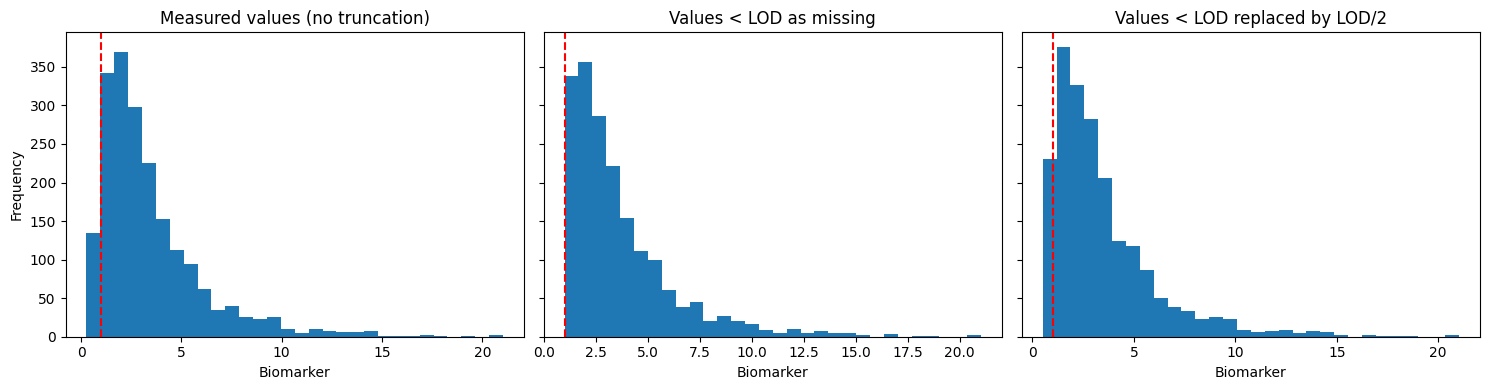

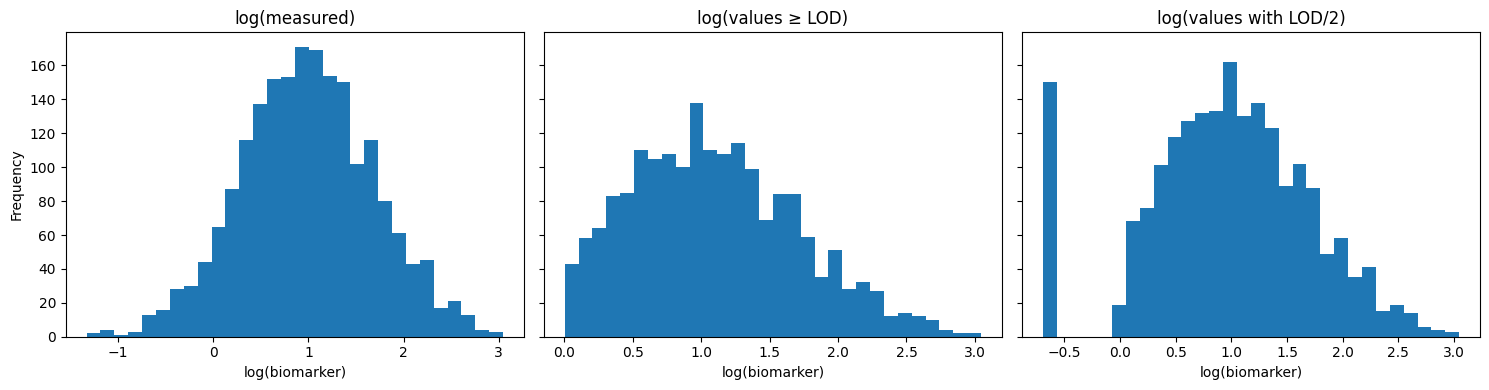

In [24]:
# Simulate a right-skewed biomarker (for example, a log-normal-like distribution)

bio_raw = np.random.lognormal(mean=1.0, sigma=0.7, size=2000)

# Assume a limit of detection (LOD)
LOD = 1.0
print("Assumed LOD:", LOD)

# Create three versions:
# 1) Values below LOD treated as missing (NaN).
# 2) Values below LOD replaced by LOD/2.
# 3) Original measured values (no truncation), for comparison.

bio_measured = bio_raw.copy()
bio_na = bio_raw.copy()
bio_const = bio_raw.copy()

bio_na[bio_na < LOD] = np.nan
bio_const[bio_const < LOD] = LOD / 2.0

print("Proportion of values below LOD:", np.mean(bio_raw < LOD))

# Plot histograms for the three approaches on the original scale
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

axes[0].hist(bio_measured, bins=30)
axes[0].axvline(LOD, color="red", linestyle="--")
axes[0].set_title("Measured values (no truncation)")
axes[0].set_xlabel("Biomarker")
axes[0].set_ylabel("Frequency")

    
axes[1].hist(bio_na[~np.isnan(bio_na)], bins=30)
axes[1].axvline(LOD, color="red", linestyle="--")
axes[1].set_title("Values < LOD as missing")
axes[1].set_xlabel("Biomarker")

axes[2].hist(bio_const, bins=30)
axes[2].axvline(LOD, color="red", linestyle="--")
axes[2].set_title("Values < LOD replaced by LOD/2")
axes[2].set_xlabel("Biomarker")

plt.tight_layout()
plt.show()

# Now apply a log transform (using a small constant to allow zeros if they appear)
eps = 1e-6
log_measured = np.log(bio_measured + eps)
log_na = np.log(bio_na + eps)
log_const = np.log(bio_const + eps)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

axes[0].hist(log_measured, bins=30)
axes[0].set_title("log(measured)")
axes[0].set_xlabel("log(biomarker)")
axes[0].set_ylabel("Frequency")

axes[1].hist(log_na[~np.isnan(log_na)], bins=30)
axes[1].set_title("log(values ≥ LOD)")
axes[1].set_xlabel("log(biomarker)")

axes[2].hist(log_const, bins=30)
axes[2].set_title("log(values with LOD/2)")
axes[2].set_xlabel("log(biomarker)")

plt.tight_layout()
plt.show()

### Exercise – thinking about truncation

- Compare the three original-scale histograms.
  - How does treating values below LOD as missing change the shape of the distribution?
  - How does replacing values below LOD by a constant (LOD/2) change it?
- Compare the three log-scale histograms.
  - Does constant substitution create an artificial spike in the distribution?
  - How might this affect model fitting and interpretation?
- In a real analysis, which approach would you choose, and what sensitivity analyses
  might you consider?

## 7. Summary, interpretation and practical rules

When transformed variables are used in models, regression coefficients change their meaning:

- **Log-transformed exposure (for example, log(intake))**  
  - A one-unit increase in log(intake) corresponds to a multiplicative change in the original intake.
  - Effects are often interpreted per *k*-fold increase (for example, per doubling), which can be
    obtained by rescaling the log variable.

- **Box–Cox transformed exposure**  
  - Coefficients are expressed in a transformed scale that is not directly intuitive.
  - Interpretation often focuses on comparing predicted outcomes at specific, back-transformed
    values rather than on a generic “one-unit change”.

- **z-scored variables (standardisation)**  
  - Effects are per 1 standard deviation increase in the original variable.
  - This facilitates comparison of effect sizes between variables but may be less intuitive for
    clinical audiences.

- **Categorised variables (for example, quantiles)**  
  - Coefficients compare categories (for example, highest vs lowest quintile) and are easy to describe.
  - However, they conceal variability within categories and depend on arbitrary cut-points.

For reporting, it is often helpful to:

- Present results both on the transformed scale (for modelling) and back-transformed or re-expressed
  in the original units (for interpretation).
- Clearly state which transformation was used, and, where relevant, which constants or parameters
  (for example, \(\lambda\) in Box–Cox, constants for LOD imputation) were applied.

### Practical rules (summary)

- Use **plots of the variable and residuals** to guide decisions; do not rely solely on formal
  normality tests.
- Consider a **log transform** for strongly right-skewed positive variables, especially where
  proportional changes are meaningful.
- Use **z-scores** when comparing effect sizes across variables on different scales.
- Use **Box–Cox** when a simple log transform is clearly inadequate and interpretability can be
  handled via back-transformation.
- Use **categorisation** sparingly; when it is required (for example, clinical thresholds), be
  explicit about cut-points and acknowledge information loss.
- For **truncated analytical values**, state clearly how values below LOD / LLOQ were handled and
  consider sensitivity analyses with alternative approaches.

### Summary table – transformations and their properties

| Approach                      | Type                 | Reversible? | Typical purpose                                     | Advantages                                          | Limitations / cautions                                   | Interpretation of 1-unit change                    |
|------------------------------|----------------------|------------|-----------------------------------------------------|-----------------------------------------------------|----------------------------------------------------------|----------------------------------------------------|
| Log(x + c)                   | Monotonic transform  | Yes        | Reduce right-skewness; stabilise variance           | Simple; widely understood; often matches biology    | Requires x + c > 0; choice of c affects tail             | Multiplicative change in original x               |
| Box–Cox(x; λ)                | Power transform      | Yes        | Reduce skewness; approximate normality              | Flexible; λ estimated from data                     | Less intuitive; sensitive to outliers and truncation      | Model-based; often via back-transforms            |
| z-score = (x − mean)/sd      | Linear transform     | Yes        | Standardise scale; compare effect sizes             | Mean 0, sd 1; easy comparison across variables      | Depends on sample distribution; less intuitive clinically | Change per 1 sd in original x                     |
| Categorisation (quantiles)   | Non-linear, discrete | No         | Simplify presentation; threshold-based decisions    | Easy to present and explain; suits decision rules   | Information loss; arbitrary cut-points; reduced power     | Category contrasts (e.g. highest vs lowest)       |
| Truncation + constant imput. | Ad hoc modification  | Partly     | Handle values < LOD / LLOQ                          | Simple; preserves sample size                       | Artificial spikes; may bias low range                     | Depends on imputation rule                        |
| Use measured values (LOD-flag)| Measurement choice  | Yes        | Retain numeric range from instrument                | Avoids artificial truncation                        | Low-range uncertainty; method-specific behaviour          | As for raw scale; note increased uncertainty      |
